Try adding one layer at a time

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt         
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline
from tensorflow.keras import models, layers, regularizers, Input
plt.rcParams["axes.grid"] = False


## Necessary Fcns

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [3]:
#try same model with resizing
dim = (100,100)

In [4]:
#loading the data using the kaggle fcn
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['../../../../archive/seg_train/seg_train', '../../../../archive/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, dim) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [5]:
(train_images_resized_100, train_labels), (test_images_resized_100, test_labels) = load_data()

  5%|▍         | 99/2191 [00:00<00:02, 989.12it/s]

Loading ../../../../archive/seg_train/seg_train


 24%|██▍       | 104/437 [00:00<00:00, 1039.08it/s]

Loading ../../../../archive/seg_test/seg_test


100%|██████████| 501/501 [00:00<00:00, 992.55it/s] 


In [6]:
def model_plots(history,name):
    plt.style.use('ggplot')
    
    fig1, ax1 = plt.subplots(figsize=(6,6))
    metrics = ['acc','val_acc']
    for metric in metrics:
        ax1 = plt.plot(history.history[metric], label=metric)
    ax1 = plt.title(f'{name}-Accuracy')

    ax1 = plt.legend()
    ax1 = plt.tight_layout()
    ax1 = plt.xlabel('Epochs')
    ax1 = plt.ylabel('Accuracy')
    fig1.savefig(f'Images/{name}-accuracy.jpg',bbox_inches='tight', dpi=150)
    
    fig2, ax2 = plt.subplots(figsize=(6,6))
    metrics = ['loss','val_loss']
    for metric in metrics:
        ax2 = plt.plot(history.history[metric], label=metric)
    ax2 = plt.title(f'{name}-Loss')

    ax2 = plt.legend()
    ax2 = plt.tight_layout()
    ax2 = plt.xlabel('Epochs')
    ax2 = plt.ylabel('Loss')
    fig2.savefig(f'Images/{name}-loss.jpg',bbox_inches='tight', dpi=150)

In [7]:
layers_list = []

def modeler(layers_list,dims):
    
    model = models.Sequential()
    model.add(layers.InputLayer(dims))
    #     model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(75, 75, 3)))
    #     model.add(layers.Conv2D(128,(3,3),activation='relu'))

    
    for layer in layers_list:
        model.add(layer)
    
    model.add(layers.Flatten())
    model.add(layers.Dense(40,activation='relu'))

    model.add(layers.Dense(6,activation='softmax'))
    
    
 
    return model

In [8]:
def model_trainer(model,name,train_img,train_labels,test_img,test_labels,batch_size=16,epochs=5,summary=False):
    
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
    
    if summary:
        return model.summary()
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'../../../../Models/{name}_model.h5', save_best_only=True)
    earlystop = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', # What to watch
                                min_delta=0.1, # How much change to get
                                patience=5 # No change after 5 epochs
    )
    history = model.fit(train_img,train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(test_img,test_labels),
                    callbacks=[checkpoint,earlystop])
    
    return history

In [9]:
def image_expl(model,image_array,name,image_label):
    '''
    Takes a model, single image array, name string of the model, and the true label of the image.
    Uses LIME to get an image explainer and plots the image and explaination.
    '''
    fig, ax = plt.subplots()

    #instantiate explainer
    explainer = lime_image.LimeImageExplainer(random_state=1)
    #explain an image caste to double bc updated keras version, pass predictor 
    explanation = explainer.explain_instance(image_array.astype('double'), model.predict)
    #show the image
    plt.imshow(image_array)
    #get the mask for the prediction
    temp, mask = explanation.get_image_and_mask(model.predict(image_array.reshape((1,100,100,3))).argmax(axis=1)[0], positive_only=False, hide_rest=False)
    #show image and mask together
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')

    plt.title(f'{name}-{image_label}')
    

    fig.savefig(f'Images/explainer/{name}-{image_label}.jpg',bbox_inches='tight', dpi=150)

In [10]:
def image_preds(model,image_array,name,image_label):
    '''
    Takes a model, single image array, name string of the model, and the true label of the image.
    Plots the class predictions for the image.
    '''
    plt.style.use('fivethirtyeight')
    plt.rcParams["axes.grid"] = False

    fig, ax = plt.subplots(figsize=(6,6))
    ax = plt.plot(range(0,6),model.predict(image_array.reshape((1,100,100,3)))[0])
    ax = plt.xticks(ticks=[0,1,2,3,4,5],labels=class_names)
    ax = plt.tight_layout()
    ax = plt.xlabel('Class Name')
    ax = plt.ylabel('Confidence')
    ax = plt.title(f'{name}-{image_label}')
    fig.savefig(f'Images/preds/{name}-{image_label}-preds.jpg',bbox_inches='tight', dpi=150)

In [11]:
#reshaping
def reshaper(array_of_imgs,height,width):
    '''
    Takes an array of RGB images and the reshaped height and width as ints. Reshapes each image to the new size and returns a new array of reshaped images.
    '''
    new_shape = np.full((len(array_of_imgs),height,width,3),None)
    for i in range(0,len(array_of_imgs),1):
        new_shape[i] = cv2.resize(array_of_imgs[i],(height,width))
    return new_shape

In [12]:
def plotter(img,name,label):
    fig, ax = plt.subplots()
    
    ax = plt.imshow(img)
    ax = plt.title(f'{name}-{label}')
    plt.axis('off')
    fig.savefig(f'Images/originals/{name}-{label}-preds.jpg',bbox_inches='tight', dpi=150)

## Data Loading

(14034, 100, 100, 3)

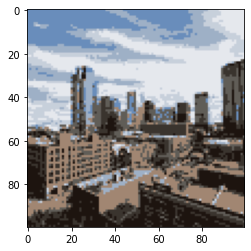

In [13]:
cck_train_100 = np.load('cck_train_100.npz')['arr_0']
plt.imshow(cck_train_100[1])
cck_train_100.shape

(3000, 100, 100, 3)

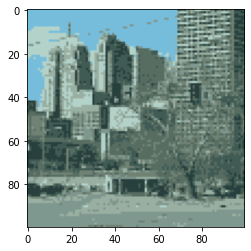

In [14]:
cck_test_100 = np.load('cck_test_100.npz')['arr_0']
plt.imshow(cck_test_100[1])
cck_test_100.shape

In [15]:
test_clustered_reshaped = reshaper(cck_test_100,100,100).astype('float32')
train_clustered_reshaped = reshaper(cck_train_100,100,100).astype('float32')

In [16]:
test_clustered_reshaped.shape

(3000, 100, 100, 3)

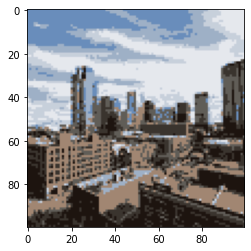

In [17]:
plt.imshow(train_clustered_reshaped[1])

## Building the Model

In [18]:
layers_list = [layers.Conv2D(128,(2,2),activation='relu'),
               ]

model = modeler(layers_list,(100,100,3))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 99, 99, 128)       1664      
_________________________________________________________________
flatten (Flatten)            (None, 1254528)           0         
_________________________________________________________________
dense (Dense)                (None, 40)                50181160  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 50,183,070
Trainable params: 50,183,070
Non-trainable params: 0
_________________________________________________________________


## Training and Plotting

In [20]:
# history = model_trainer(model,'singleConv2D',
#                         train_clustered_reshaped,train_labels,
#                         test_clustered_reshaped,test_labels,
#                         batch_size=32,
#                         epochs=20,
#                         summary=False)

In [21]:
# model_plots(history,'singleConv2D')

In [22]:
import lime
plt.rcParams["axes.grid"] = False
from lime import lime_image
from skimage.segmentation import mark_boundaries
import random

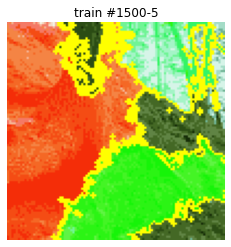

In [23]:
# image_expl(model,test_clustered_reshaped[500],'train #1500',test_labels[500])

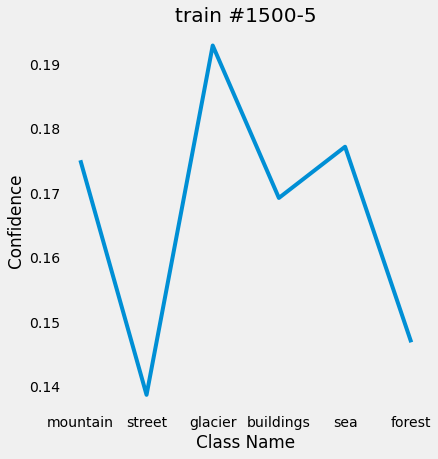

In [24]:
# image_preds(model,test_clustered_reshaped[500],'train #1500',test_labels[500])

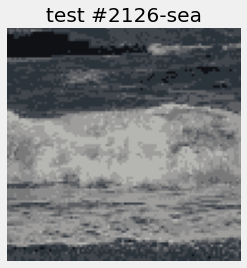

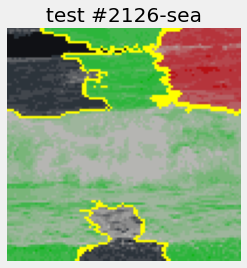

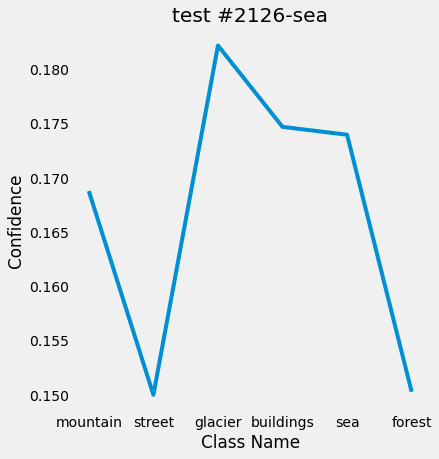

In [25]:
#Now I'm getting explainers for ten images at a time to look at. Then, I find good ones to use in the presentation.
# rand_img = np.random.randint(0,3000,1)
# # rand_img = [1347]
# class_map = {0:'mountain',1:'street',2:'glacier',3:'buildings',4:'sea',5:'forest'}

# for num in rand_img:
#     label = class_map[test_labels[num]]
#     plotter(test_clustered_reshaped[num],f'test #{num}',label)
#     image_expl(model,test_clustered_reshaped[num],f'test #{num}',label)
#     image_preds(model,test_clustered_reshaped[num],f'test #{num}',label)

## Testing VGG-16 Model Architecture Types

https://arxiv.org/abs/1409.1556

It is now apparent that using a gpu for this kind of processing is required as well as more memory. I cut down the model quite a bit and it will run (slowly). It seems like the flatten layer caused the issue because the number of params increases drastically there.

In [30]:
layers_list = []

def modeler(layers_list,dims):
    
    model = models.Sequential()
    model.add(layers.InputLayer(dims))
    
    for layer in layers_list:
        model.add(layer)

    model.add(layers.Dense(6,activation='softmax'))
    return model

In [31]:
layers_list = [layers.Conv2D(64,(3,3),activation='relu'),
               layers.Conv2D(128,(3,3),activation='relu'),
               layers.MaxPooling2D(2,2),
               layers.Flatten(),
               layers.Dense(512,activation='relu')
               ]

model = modeler(layers_list,(100,100,3))

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 98, 98, 64)        1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 96, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 294912)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               150995456 
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 3078      
Total params: 151,074,182
Trainable params: 151,074,182
Non-trainable params: 0
________________________________________

## Training and Plotting

In [33]:
history = model_trainer(model,'ConvNet-A',
                        train_clustered_reshaped,train_labels,
                        test_clustered_reshaped,test_labels,
                        batch_size=32,
                        epochs=5,
                        summary=False)

Epoch 1/5
153/439 [=========>....................] - ETA: 5:26 - loss: 1.7225 - acc: 0.4894

KeyboardInterrupt: 

In [ ]:
model_plots(history,'ConvNet-A')